In [1]:
import re
import math
import time
import copy
import random
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from datasets import load_dataset
from myTokenize import SyllableTokenizer
from tqdm import tqdm

/Users/thetsusann/Desktop/NLP/Assignments/Assignment3-Machine Translation/mt39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/thetsusann/Desktop/NLP/Assignments/Assignment3-Machine Translation/mt39/lib/python3.9/site-packages/google/api_core/_python_version_support.py:246: FutureWarning: You are using a non-supported Python version (3.9.6). Google will not post any further updates to google.api_core supporting this Python version. Please upgrade to the latest Python version, or at least Python 3.10, and then update google.api_core.
  warnings.warn(message, FutureWarning)
/Users/thetsusann/Desktop/NLP/Assignments/Assignment3-Machine Translation/mt39/lib/python3.9/site-packages/google/auth/__init__.py:54: FutureWarning: You are using a Python version 3.9 past its end of life. Google will update goo

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# Load ALT parallel dataset
ds = load_dataset("mutiyama/alt", "alt-parallel")

mm_tok = SyllableTokenizer()

def tokenize_mm(text: str):
    return mm_tok.tokenize(text.strip())

_en_punct = re.compile(r"([?.!,¿])")
def tokenize_en(text: str):
    text = text.strip().lower()
    text = _en_punct.sub(r" \1 ", text)
    text = re.sub(r"\s+", " ", text)
    return text.split()

pairs_tok = []
skipped = 0

for ex in ds["train"]:
    mm = ex["translation"].get("my", None)
    en = ex["translation"].get("en", None)
    if not mm or not en:
        skipped += 1
        continue
    mm_toks = tokenize_mm(mm)
    en_toks = tokenize_en(en)
    if len(mm_toks) == 0 or len(en_toks) == 0:
        skipped += 1
        continue
    pairs_tok.append((mm_toks, en_toks))

print("Tokenized pairs:", len(pairs_tok))
print("Skipped:", skipped)
print("Example MM:", pairs_tok[0][0][:25])
print("Example EN:", pairs_tok[0][1][:25])

Tokenized pairs: 18082
Skipped: 6
Example MM: ['ပြင်', 'သစ်', 'နိုင်', 'ငံ', 'ပါ', 'ရီ', 'မြို့', 'ပါ့', 'ဒက်စ်', 'ပ', 'ရင့်', 'စက်', '၌', '၂', '၀', '၀', '၇', 'ခု', 'နှစ်', 'ရပ်', 'ဘီ', 'ကမ္ဘာ့', 'ဖ', 'လား', 'တွင်']
Example EN: ['italy', 'have', 'defeated', 'portugal', '31-5', 'in', 'pool', 'c', 'of', 'the', '2007', 'rugby', 'world', 'cup', 'at', 'parc', 'des', 'princes', ',', 'paris', ',', 'france', '.']


In [4]:
random.shuffle(pairs_tok)
val_ratio = 0.10
n_val = int(len(pairs_tok) * val_ratio)

val_pairs = pairs_tok[:n_val]
train_pairs = pairs_tok[n_val:]

print("Train pairs:", len(train_pairs))
print("Val pairs:", len(val_pairs))

Train pairs: 16274
Val pairs: 1808


In [5]:
PAD = "<pad>"
SOS = "<sos>"
EOS = "<eos>"
UNK = "<unk>"
SPECIALS = [PAD, SOS, EOS, UNK]

def build_vocab(token_seqs, min_freq=2):
    counter = Counter()
    for seq in token_seqs:
        counter.update(seq)
    vocab = SPECIALS.copy()
    for tok, freq in counter.items():
        if freq >= min_freq and tok not in vocab:
            vocab.append(tok)
    tok2i = {tok:i for i, tok in enumerate(vocab)}
    i2tok = {i:tok for tok,i in tok2i.items()}
    return tok2i, i2tok, counter

mm_train = [mm for mm, en in train_pairs]
en_train = [en for mm, en in train_pairs]

mm2i, i2mm, mm_counter = build_vocab(mm_train, min_freq=2)
en2i, i2en, en_counter = build_vocab(en_train, min_freq=2)

print("Myanmar vocab:", len(mm2i))
print("English vocab:", len(en2i))
print("PAD idx:", mm2i[PAD], en2i[PAD])

Myanmar vocab: 3143
English vocab: 15393
PAD idx: 0 0


In [6]:
MAX_MM_LEN = 60
MAX_EN_LEN = 60
BATCH_SIZE = 64

In [7]:
def tokens_to_ids(tokens, tok2i):
    return [tok2i.get(t, tok2i[UNK]) for t in tokens]

def make_example(mm_tokens, en_tokens, max_mm_len=60, max_en_len=60):
    # truncate (leave room for special)
    mm_tokens = mm_tokens[:max_mm_len-1]
    en_tokens = en_tokens[:max_en_len-1]

    src = tokens_to_ids(mm_tokens + [EOS], mm2i)           # encoder input
    dec_in  = tokens_to_ids([SOS] + en_tokens, en2i)       # decoder input
    dec_out = tokens_to_ids(en_tokens + [EOS], en2i)       # target

    return src, dec_in, dec_out

class MTDataset(Dataset):
    def __init__(self, pairs, max_mm_len=60, max_en_len=60):
        self.pairs = pairs
        self.max_mm_len = max_mm_len
        self.max_en_len = max_en_len

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        mm_tokens, en_tokens = self.pairs[idx]
        src, dec_in, dec_out = make_example(mm_tokens, en_tokens,
                                            max_mm_len=self.max_mm_len,
                                            max_en_len=self.max_en_len)
        return torch.tensor(src), torch.tensor(dec_in), torch.tensor(dec_out)

def collate_mt(batch, pad_src, pad_tgt):
    srcs, dec_ins, dec_outs = zip(*batch)
    src_lens = torch.tensor([len(x) for x in srcs], dtype=torch.long)
    tgt_lens = torch.tensor([len(x) for x in dec_ins], dtype=torch.long)

    max_src = max(src_lens).item()
    max_tgt = max(tgt_lens).item()

    src_pad = torch.full((len(batch), max_src), pad_src, dtype=torch.long)
    dec_in_pad  = torch.full((len(batch), max_tgt), pad_tgt, dtype=torch.long)
    dec_out_pad = torch.full((len(batch), max_tgt), pad_tgt, dtype=torch.long)

    for i, (s, di, do) in enumerate(zip(srcs, dec_ins, dec_outs)):
        src_pad[i, :len(s)] = s
        dec_in_pad[i, :len(di)] = di
        dec_out_pad[i, :len(do)] = do

    src_mask = (src_pad != pad_src)
    tgt_mask = (dec_in_pad != pad_tgt)

    return src_pad, src_lens, src_mask, dec_in_pad, dec_out_pad, tgt_lens, tgt_mask

train_ds = MTDataset(train_pairs, max_mm_len=MAX_MM_LEN, max_en_len=MAX_EN_LEN)
val_ds   = MTDataset(val_pairs,   max_mm_len=MAX_MM_LEN, max_en_len=MAX_EN_LEN)

pad_src = mm2i[PAD]
pad_tgt = en2i[PAD]

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=lambda b: collate_mt(b, pad_src, pad_tgt))
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        collate_fn=lambda b: collate_mt(b, pad_src, pad_tgt))

# sanity
batch = next(iter(train_loader))
src_pad, src_lens, src_mask, dec_in_pad, dec_out_pad, tgt_lens, tgt_mask = batch
print(src_pad.shape, dec_in_pad.shape, dec_out_pad.shape)


torch.Size([64, 60]) torch.Size([64, 60]) torch.Size([64, 60])


In [8]:
class GeneralAttention(nn.Module):
    # e_i = s^T h_i
    def __init__(self):
        super().__init__()

    def forward(self, decoder_state, encoder_outputs, src_mask):
        scores = torch.bmm(encoder_outputs, decoder_state.unsqueeze(2)).squeeze(2)
        scores = scores.masked_fill(~src_mask, -1e9)
        attn_weights = F.softmax(scores, dim=1)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context, attn_weights


class AdditiveAttention(nn.Module):
    # e_i = v^T tanh(W1 h_i + W2 s)
    def __init__(self, hid_dim):
        super().__init__()
        self.W1 = nn.Linear(hid_dim, hid_dim, bias=False)
        self.W2 = nn.Linear(hid_dim, hid_dim, bias=False)
        self.v  = nn.Linear(hid_dim, 1, bias=False)

    def forward(self, decoder_state, encoder_outputs, src_mask):
        dec = self.W2(decoder_state).unsqueeze(1)  # (bs,1,hid)
        energy = torch.tanh(self.W1(encoder_outputs) + dec)
        scores = self.v(energy).squeeze(2)
        scores = scores.masked_fill(~src_mask, -1e9)
        attn_weights = F.softmax(scores, dim=1)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context, attn_weights


In [9]:
class Encoder(nn.Module):
    def __init__(self, src_vocab_size, emb_dim, hid_dim, pad_idx, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(src_vocab_size, emb_dim, padding_idx=pad_idx)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(emb_dim, hid_dim, batch_first=True)

    def forward(self, src_ids, src_lens):
        emb = self.dropout(self.embedding(src_ids))
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, src_lens.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_out, (h, c) = self.lstm(packed)
        encoder_outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        return encoder_outputs, (h, c)


class Decoder(nn.Module):
    def __init__(self, tgt_vocab_size, emb_dim, hid_dim, pad_idx, attention, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(tgt_vocab_size, emb_dim, padding_idx=pad_idx)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(emb_dim + hid_dim, hid_dim, batch_first=True)
        self.attention = attention
        self.fc_out = nn.Linear(hid_dim + hid_dim, tgt_vocab_size)

    def forward(self, input_token, hidden, cell, encoder_outputs, src_mask):
        emb = self.dropout(self.embedding(input_token)).unsqueeze(1)
        dec_state = hidden[-1]  # (bs,hid)
        context, attn_weights = self.attention(dec_state, encoder_outputs, src_mask)
        context = context.unsqueeze(1)
        lstm_in = torch.cat([emb, context], dim=2)
        out, (hidden, cell) = self.lstm(lstm_in, (hidden, cell))
        out = out.squeeze(1)
        context = context.squeeze(1)
        logits = self.fc_out(torch.cat([out, context], dim=1))
        return logits, hidden, cell, attn_weights


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, sos_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sos_idx = sos_idx
        self.device = device

    def forward(self, src_ids, src_lens, src_mask, dec_in_ids, teacher_forcing=True):
        bs, tgt_len = dec_in_ids.shape
        encoder_outputs, (h, c) = self.encoder(src_ids, src_lens)

        vocab_size = self.decoder.fc_out.out_features
        logits = torch.zeros(bs, tgt_len, vocab_size, device=self.device)
        attn_maps = torch.zeros(bs, tgt_len, encoder_outputs.size(1), device=self.device)

        input_tok = dec_in_ids[:, 0]  # SOS

        for t in range(1, tgt_len):
            step_logits, h, c, attn_w = self.decoder(input_tok, h, c, encoder_outputs, src_mask)
            logits[:, t] = step_logits
            attn_maps[:, t] = attn_w

            if teacher_forcing:
                input_tok = dec_in_ids[:, t]
            else:
                input_tok = step_logits.argmax(dim=1)

        return logits, attn_maps


In [10]:
criterion = nn.CrossEntropyLoss(ignore_index=en2i[PAD])

def compute_loss(logits, targets):
    logits = logits[:, 1:, :]   # skip t=0
    targets = targets[:, 1:]
    bs, tl, vocab = logits.shape
    logits = logits.reshape(bs*tl, vocab)
    targets = targets.reshape(bs*tl)
    return criterion(logits, targets)

def train_one_epoch(model, loader, optimizer, clip=1.0):
    model.train()
    total = 0.0
    for batch in tqdm(loader, leave=False):
        src_pad, src_lens, src_mask, dec_in_pad, dec_out_pad, tgt_lens, tgt_mask = [x.to(device) for x in batch]
        optimizer.zero_grad()
        logits, _ = model(src_pad, src_lens, src_mask, dec_in_pad, teacher_forcing=True)
        loss = compute_loss(logits, dec_out_pad)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        total += loss.item()
    avg = total / len(loader)
    ppl = math.exp(avg) if avg < 50 else float("inf")
    return avg, ppl

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total = 0.0
    for batch in tqdm(loader, leave=False):
        src_pad, src_lens, src_mask, dec_in_pad, dec_out_pad, tgt_lens, tgt_mask = [x.to(device) for x in batch]
        logits, _ = model(src_pad, src_lens, src_mask, dec_in_pad, teacher_forcing=True)
        loss = compute_loss(logits, dec_out_pad)
        total += loss.item()
    avg = total / len(loader)
    ppl = math.exp(avg) if avg < 50 else float("inf")
    return avg, ppl


In [11]:
def run_experiment_earlystop(attn_type="additive",
                             max_epochs=30,
                             patience=4,
                             lr=1e-3,
                             emb_dim=128,
                             hid_dim=128,
                             clip=1.0,
                             save_path="best.pt"):
    if attn_type == "general":
        attn = GeneralAttention()
    elif attn_type == "additive":
        attn = AdditiveAttention(hid_dim)
    else:
        raise ValueError("attn_type must be 'general' or 'additive'")

    enc = Encoder(len(mm2i), emb_dim, hid_dim, pad_idx=mm2i[PAD], dropout=0.2)
    dec = Decoder(len(en2i), emb_dim, hid_dim, pad_idx=en2i[PAD], attention=attn, dropout=0.2)
    model = Seq2Seq(enc, dec, sos_idx=en2i[SOS], device=device).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss": [], "val_loss": [], "train_ppl": [], "val_ppl": []}
    best_val = float("inf")
    best_state = None
    bad = 0

    for epoch in range(1, max_epochs+1):
        t0 = time.time()
        tr_loss, tr_ppl = train_one_epoch(model, train_loader, optimizer, clip=clip)
        va_loss, va_ppl = evaluate(model, val_loader)
        dt = time.time() - t0

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_ppl"].append(tr_ppl)
        history["val_ppl"].append(va_ppl)

        print(f"[{attn_type}] Epoch {epoch}/{max_epochs} | "
              f"train_loss={tr_loss:.4f} ppl={tr_ppl:.2f} | "
              f"val_loss={va_loss:.4f} ppl={va_ppl:.2f} | "
              f"time={dt:.1f}s")

        if va_loss < best_val - 1e-4:
            best_val = va_loss
            best_state = copy.deepcopy(model.state_dict())
            torch.save(best_state, save_path)
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                print(f"Early stopping (patience={patience})")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history


In [12]:
best_gen_model, gen_hist = run_experiment_earlystop(
    attn_type="general",
    max_epochs=30,
    patience=4,
    lr=1e-3,
    emb_dim=128,
    hid_dim=128,
    save_path="best_general.pt"
)

best_add_model, add_hist = run_experiment_earlystop(
    attn_type="additive",
    max_epochs=30,
    patience=4,
    lr=1e-3,
    emb_dim=128,
    hid_dim=128,
    save_path="best_additive.pt"
)


[general] Epoch 1/30 | train_loss=6.7779 ppl=878.23 | val_loss=6.2669 ppl=526.82 | time=141.4s


[general] Epoch 2/30 | train_loss=6.3595 ppl=577.94 | val_loss=6.1417 ppl=464.87 | time=143.8s


[general] Epoch 3/30 | train_loss=6.1977 ppl=491.60 | val_loss=6.0486 ppl=423.52 | time=139.5s


[general] Epoch 4/30 | train_loss=6.0445 ppl=421.79 | val_loss=5.9778 ppl=394.57 | time=137.9s


[general] Epoch 5/30 | train_loss=5.8986 ppl=364.51 | val_loss=5.9039 ppl=366.46 | time=137.4s


[general] Epoch 6/30 | train_loss=5.7537 ppl=315.35 | val_loss=5.8514 ppl=347.74 | time=138.7s


[general] Epoch 7/30 | train_loss=5.6142 ppl=274.29 | val_loss=5.8098 ppl=333.56 | time=138.2s


[general] Epoch 8/30 | train_loss=5.4770 ppl=239.12 | val_loss=5.7740 ppl=321.81 | time=136.4s


[general] Epoch 9/30 | train_loss=5.3457 ppl=209.70 | val_loss=5.7394 ppl=310.88 | time=137.2s


[general] Epoch 10/30 | train_loss=5.2184 ppl=184.64 | val_loss=5.7226 ppl=305.69 | time=139.2s


[general] Epoch 11/30 | train_loss=5.0978 ppl=163.66 | val_loss=5.7081 ppl=301.28 | time=138.1s


[general] Epoch 12/30 | train_loss=4.9814 ppl=145.68 | val_loss=5.6949 ppl=297.33 | time=144.3s


[general] Epoch 13/30 | train_loss=4.8688 ppl=130.16 | val_loss=5.6907 ppl=296.09 | time=138.0s


[general] Epoch 14/30 | train_loss=4.7628 ppl=117.08 | val_loss=5.6861 ppl=294.74 | time=136.8s


[general] Epoch 15/30 | train_loss=4.6603 ppl=105.67 | val_loss=5.6922 ppl=296.56 | time=137.2s


[general] Epoch 16/30 | train_loss=4.5659 ppl=96.15 | val_loss=5.6932 ppl=296.83 | time=137.0s


[general] Epoch 17/30 | train_loss=4.4757 ppl=87.86 | val_loss=5.6983 ppl=298.37 | time=138.0s


[general] Epoch 18/30 | train_loss=4.3897 ppl=80.62 | val_loss=5.6999 ppl=298.82 | time=137.7s
Early stopping (patience=4)


[additive] Epoch 1/30 | train_loss=6.7944 ppl=892.86 | val_loss=6.2757 ppl=531.49 | time=147.9s


[additive] Epoch 2/30 | train_loss=6.3738 ppl=586.28 | val_loss=6.1432 ppl=465.54 | time=146.6s


[additive] Epoch 3/30 | train_loss=6.1887 ppl=487.20 | val_loss=6.0150 ppl=409.55 | time=147.6s


[additive] Epoch 4/30 | train_loss=6.0051 ppl=405.48 | val_loss=5.9212 ppl=372.85 | time=146.8s


[additive] Epoch 5/30 | train_loss=5.8338 ppl=341.66 | val_loss=5.8422 ppl=344.55 | time=146.7s


[additive] Epoch 6/30 | train_loss=5.6698 ppl=289.99 | val_loss=5.7755 ppl=322.32 | time=453.0s


[additive] Epoch 7/30 | train_loss=5.5073 ppl=246.49 | val_loss=5.7261 ppl=306.78 | time=148.3s


[additive] Epoch 8/30 | train_loss=5.3515 ppl=210.93 | val_loss=5.6839 ppl=294.09 | time=147.7s


[additive] Epoch 9/30 | train_loss=5.1978 ppl=180.87 | val_loss=5.6401 ppl=281.50 | time=148.6s


[additive] Epoch 10/30 | train_loss=5.0533 ppl=156.54 | val_loss=5.6199 ppl=275.87 | time=147.8s


[additive] Epoch 11/30 | train_loss=4.9186 ppl=136.81 | val_loss=5.6084 ppl=272.71 | time=153.1s


[additive] Epoch 12/30 | train_loss=4.7912 ppl=120.45 | val_loss=5.5963 ppl=269.42 | time=146.6s


[additive] Epoch 13/30 | train_loss=4.6728 ppl=106.99 | val_loss=5.5918 ppl=268.21 | time=146.1s


[additive] Epoch 14/30 | train_loss=4.5605 ppl=95.63 | val_loss=5.5935 ppl=268.67 | time=146.7s


[additive] Epoch 15/30 | train_loss=4.4540 ppl=85.97 | val_loss=5.5988 ppl=270.10 | time=145.9s


[additive] Epoch 16/30 | train_loss=4.3579 ppl=78.09 | val_loss=5.5993 ppl=270.25 | time=148.1s


[additive] Epoch 17/30 | train_loss=4.2677 ppl=71.36 | val_loss=5.6058 ppl=272.01 | time=146.7s
Early stopping (patience=4)


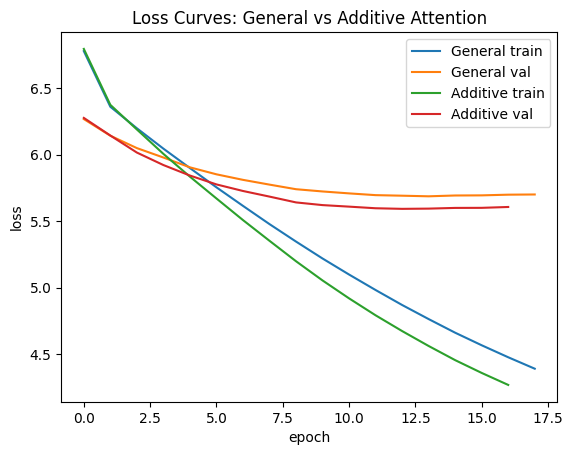

In [13]:
plt.figure()
plt.plot(gen_hist["train_loss"], label="General train")
plt.plot(gen_hist["val_loss"], label="General val")
plt.plot(add_hist["train_loss"], label="Additive train")
plt.plot(add_hist["val_loss"], label="Additive val")
plt.title("Loss Curves: General vs Additive Attention")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [14]:
summary = pd.DataFrame([
    {
        "Attention": "General",
        "Train Loss": gen_hist["train_loss"][-1],
        "Train PPL": gen_hist["train_ppl"][-1],
        "Val Loss": add_hist["val_loss"][-1] if False else gen_hist["val_loss"][-1],
        "Val PPL": gen_hist["val_ppl"][-1],
    },
    {
        "Attention": "Additive",
        "Train Loss": add_hist["train_loss"][-1],
        "Train PPL": add_hist["train_ppl"][-1],
        "Val Loss": add_hist["val_loss"][-1],
        "Val PPL": add_hist["val_ppl"][-1],
    }
])
summary

,Attention,Train Loss,Train PPL,Val Loss,Val PPL
0,General,4.389722,80.617975,5.699852,298.823297
1,Additive,4.267690,71.356590,5.605825,272.006367


/var/folders/qj/sypsr4hs17z923tv3v1dkt3w0000gn/T/ipykernel_33917/2670788836.py:42: UserWarning: Glyph 4161 (\N{MYANMAR DIGIT ONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qj/sypsr4hs17z923tv3v1dkt3w0000gn/T/ipykernel_33917/2670788836.py:42: UserWarning: Glyph 4169 (\N{MYANMAR DIGIT NINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qj/sypsr4hs17z923tv3v1dkt3w0000gn/T/ipykernel_33917/2670788836.py:42: UserWarning: Glyph 4166 (\N{MYANMAR DIGIT SIX}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qj/sypsr4hs17z923tv3v1dkt3w0000gn/T/ipykernel_33917/2670788836.py:42: UserWarning: Glyph 4165 (\N{MYANMAR DIGIT FIVE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qj/sypsr4hs17z923tv3v1dkt3w0000gn/T/ipykernel_33917/2670788836.py:42: UserWarning: Glyph 4097 (\N{MYANMAR LETTER KHA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qj/sypsr4hs17z923tv3v1dkt3w0000gn/T/ipykernel_33917/26

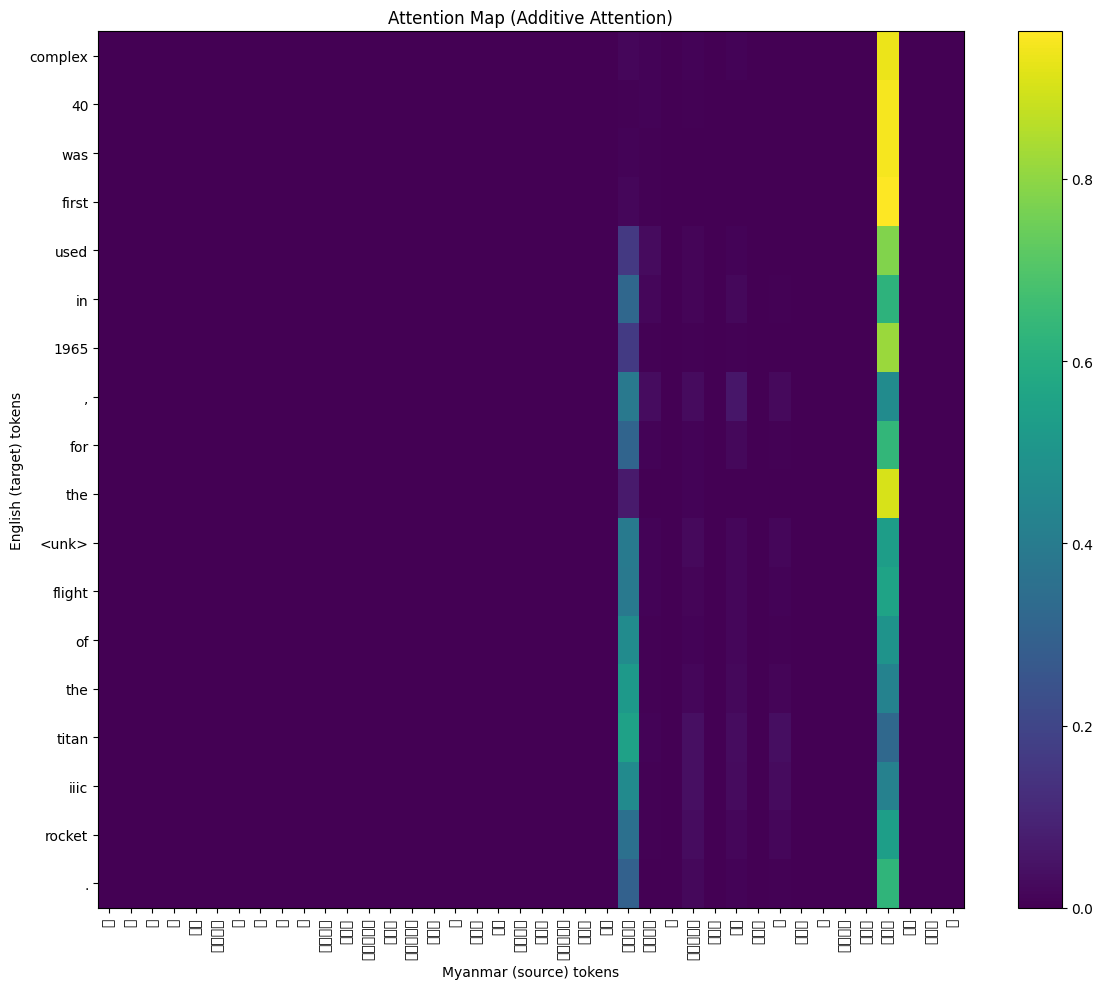

In [15]:
def ids_to_tokens(ids, idx2tok, eos_idx=None):
    out = []
    for i in ids:
        i = int(i)
        tok = idx2tok.get(i, UNK)
        if eos_idx is not None and i == eos_idx:
            break
        out.append(tok)
    return out

@torch.no_grad()
def show_attention_map(model, sample_idx=0, max_tgt_tokens=30, max_src_tokens=40):
    model.eval()
    src_ids, dec_in_ids, dec_out_ids = val_ds[sample_idx]

    src = src_ids.unsqueeze(0).to(device)
    dec_in = dec_in_ids.unsqueeze(0).to(device)

    src_lens = torch.tensor([src.size(1)], device=device)
    src_mask = (src != mm2i[PAD])

    logits, attn_maps = model(src, src_lens, src_mask, dec_in, teacher_forcing=True)

    src_tokens = ids_to_tokens(src_ids, i2mm, eos_idx=mm2i[EOS])[:max_src_tokens]
    tgt_tokens = ids_to_tokens(dec_out_ids, i2en, eos_idx=en2i[EOS])[:max_tgt_tokens]

    A = attn_maps.squeeze(0)  # (tgt_len, src_len)

    tgt_len = len(tgt_tokens)
    src_len = len(src_tokens)

    A_trim = A[1:tgt_len+1, :src_len].detach().cpu()

    plt.figure(figsize=(min(12, 0.35*src_len + 4), min(10, 0.35*tgt_len + 4)))
    plt.imshow(A_trim, aspect="auto")
    plt.yticks(range(tgt_len), tgt_tokens)
    plt.xticks(range(src_len), src_tokens, rotation=90)
    plt.xlabel("Myanmar (source) tokens")
    plt.ylabel("English (target) tokens")
    plt.title("Attention Map (Additive Attention)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

show_attention_map(best_add_model, sample_idx=0)

In [16]:
@torch.no_grad()
def translate_mm_to_en(model, sentence_mm, max_len=40):
    model.eval()

    mm_tokens = tokenize_mm(sentence_mm)
    src_ids = tokens_to_ids(mm_tokens + [EOS], mm2i)

    src = torch.tensor(src_ids).unsqueeze(0).to(device)
    src_lens = torch.tensor([len(src_ids)], device=device)
    src_mask = (src != mm2i[PAD])

    encoder_outputs, (h, c) = model.encoder(src, src_lens)

    cur = torch.tensor([en2i[SOS]], device=device)
    out_tokens = []
    last_id = None

    for _ in range(max_len):
        logits, h, c, _ = model.decoder(cur, h, c, encoder_outputs, src_mask)

        # small anti-repeat trick
        top2 = logits.topk(2, dim=1).indices.squeeze(0).tolist()
        nxt = top2[0]
        if last_id is not None and nxt == last_id:
            nxt = top2[1]
        last_id = nxt

        if nxt == en2i[EOS]:
            break
        out_tokens.append(i2en.get(nxt, UNK))
        cur = torch.tensor([nxt], device=device)

    return " ".join(out_tokens)

print(translate_mm_to_en(best_add_model, "မြန်မာနိုင်ငံ"))

to the . , .


In [17]:
# Save vocab so your app later can load it
torch.save({
    "mm2i": mm2i,
    "en2i": en2i,
    "i2mm": i2mm,
    "i2en": i2en
}, "vocabs.pt")

In [18]:
@torch.no_grad()
def translate_beam(model, sentence_mm, beam_size=3, max_len=40, length_penalty=0.7):
    model.eval()

    # tokenize + ids
    mm_tokens = tokenize_mm(sentence_mm)
    src_ids = tokens_to_ids(mm_tokens + [EOS], mm2i)
    src = torch.tensor(src_ids).unsqueeze(0).to(device)
    src_lens = torch.tensor([len(src_ids)], device=device)
    src_mask = (src != mm2i[PAD])

    encoder_outputs, (h0, c0) = model.encoder(src, src_lens)

    # beam items: (tokens, logprob, h, c)
    beams = [([en2i[SOS]], 0.0, h0, c0)]
    finished = []

    for _ in range(max_len):
        new_beams = []

        for toks, logp, h, c in beams:
            last = toks[-1]
            if last == en2i[EOS]:
                finished.append((toks, logp))
                continue

            cur = torch.tensor([last], device=device)
            logits, h2, c2, _ = model.decoder(cur, h, c, encoder_outputs, src_mask)
            log_probs = F.log_softmax(logits, dim=1).squeeze(0)  # (vocab,)

            # anti-repeat: discourage repeating the same token
            if len(toks) >= 2:
                log_probs[toks[-1]] -= 1.0

            topk = torch.topk(log_probs, beam_size)

            for next_id, next_lp in zip(topk.indices.tolist(), topk.values.tolist()):
                new_toks = toks + [next_id]
                new_beams.append((new_toks, logp + next_lp, h2, c2))

        if not new_beams:
            break

        # rank beams with length penalty
        def score(item):
            toks, logp, *_ = item
            L = max(1, len(toks) - 1)
            return logp / (L ** length_penalty)

        new_beams.sort(key=score, reverse=True)
        beams = new_beams[:beam_size]

    finished.extend([(toks, logp) for toks, logp, *_ in beams])

    # choose best finished
    def final_score(toks_logp):
        toks, logp = toks_logp
        L = max(1, len(toks) - 1)
        return logp / (L ** length_penalty)

    best_toks, best_logp = max(finished, key=final_score)

    # convert to words
    out = []
    for tid in best_toks[1:]:  # skip SOS
        if tid == en2i[EOS]:
            break
        out.append(i2en.get(tid, UNK))
    return " ".join(out)

In [21]:
print(translate_beam(best_add_model, "၁၉၆၅ခုနှစ်၌ပထမဆုံးပစ်လွှတ်သောတိုင်တမ်သရီးစီဒုံးပျံလွှတ်တင်ရာတွင်ကွမ်ပလက်စ်ဖောတိကိုစတင်အသုံးပြုခဲ့ပါသည်။"))

first in first in first in first the was in first in . . . . . .


In [20]:
def detok_mm(tokens):
    return "".join(tokens)

def detok_en(tokens):
    return " ".join(tokens)

for idx in [0, 1, 2, 3, 4]:
    mm_toks, en_toks = val_pairs[idx]
    mm_text = detok_mm(mm_toks)
    gold = detok_en(en_toks)
    pred = translate_beam(best_add_model, mm_text)

    print("----")
    print("MM:", mm_text[:120])
    print("GOLD:", gold[:120])
    print("PRED:", pred[:120])

----
MM: ၁၉၆၅ခုနှစ်၌ပထမဆုံးပစ်လွှတ်သောတိုင်တမ်သရီးစီဒုံးပျံလွှတ်တင်ရာတွင်ကွမ်ပလက်စ်ဖောတိကိုစတင်အသုံးပြုခဲ့ပါသည်။
GOLD: complex 40 was first used in 1965 , for the maiden flight of the titan iiic rocket .
PRED: first in first in first in first the was in first in . . . . . .
----
MM: တစ်နေ့တာအတွင်းပြင်းထန်တဲ့အကြမ်းဖက်မှုများ၁၀၀နီးပါးရှိသည်ဟုအတည်ပြုခဲ့ပြီး၊အရေအတွက်၁၅၀အထိမြင့်တက်လာနိုင်တယ်လို့ယုံကြည်ပါကြ
GOLD: the independent operating organisation centre for monitoring election violence said it had confirmed close to a hundred 
PRED: the said the of , the said the was to the of , the of , the was to the of , the of , the of , the was to the of for , th
----
MM: အခြားသောလှည့်ကင်းမော်တော်ကားနှင့်လာခဲ့သော၊ဒုတိယဗိုလ်မှူးကြီးသည်၊သူတို့ကိုသူတို့၏ကိုယ်ပိုင်လုံခြုံရေးအတွက်ရွာထဲသို့၀င်ခွင
GOLD: lieutenant colonel , who came with another patrol car , explained that they are not allowed to the village for their own
PRED: <unk> , <unk> , <unk> , <unk> , <unk> , they the were to their to their . .
--